# Simple Grid World - GYM

In [32]:
import numpy as np
from hiive.mdptoolbox import mdp
import matplotlib.pyplot as plt
import json
from gym.envs import toy_text

In [46]:
import sys
from contextlib import closing

import numpy as np
from io import StringIO

from gym import utils
from gym.envs.toy_text import discrete

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

MAPS = {
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ],
}


def generate_random_map(size=8, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0, 0))
        while frontier:
            r, c = frontier.pop()
            if not (r, c) in discovered:
                discovered.add((r, c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] != 'H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]


class FrozenLakeEnv(discrete.DiscreteEnv):
    """
    Winter is here. You and your friends were tossing around a frisbee at the
    park when you made a wild throw that left the frisbee out in the middle of
    the lake. The water is mostly frozen, but there are a few holes where the
    ice has melted. If you step into one of those holes, you'll fall into the
    freezing water. At this time, there's an international frisbee shortage, so
    it's absolutely imperative that you navigate across the lake and retrieve
    the disc. However, the ice is slippery, so you won't always move in the
    direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.
    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, desc=None, map_name="4x4", is_slippery=True):
        if desc is None and map_name is None:
            desc = generate_random_map()
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc, dtype='c')
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol

        isd = np.array(desc == b'S').astype('float64').ravel()
        isd /= isd.sum()

        P = {s: {a: [] for a in range(nA)} for s in range(nS)}

        def to_s(row, col):
            return row*ncol + col

        def inc(row, col, a):
            if a == LEFT:
                col = max(col - 1, 0)
            elif a == DOWN:
                row = min(row + 1, nrow - 1)
            elif a == RIGHT:
                col = min(col + 1, ncol - 1)
            elif a == UP:
                row = max(row - 1, 0)
            return (row, col)

        def update_probability_matrix(row, col, action):
            newrow, newcol = inc(row, col, action)
            newstate = to_s(newrow, newcol)
            newletter = desc[newrow, newcol]
            done = bytes(newletter) in b'GH'
            reward = 1 if bytes(b'G') else -1 if bytes(b'H') else -0.1
            return newstate, reward, done

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = P[s][a]
                    letter = desc[row, col]
                    if letter in b'GH':
                        li.append((1.0, s, 0, True))
                    else:
                        if is_slippery:
                            for b in [(a - 1) % 4, a, (a + 1) % 4]:
                                li.append((
                                    1. / 3.,
                                    *update_probability_matrix(row, col, b)
                                ))
                        else:
                            li.append((
                                1., *update_probability_matrix(row, col, a)
                            ))

        super(FrozenLakeEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode('utf-8') for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(
                ["Left", "Down", "Right", "Up"][self.lastaction]))
        else:
            outfile.write("\n")
        outfile.write("\n".join(''.join(line) for line in desc)+"\n")

        if mode != 'human':
            with closing(outfile):
                return outfile.getvalue()

In [47]:
def get_TR_values(map_name="4x4"):
    env = FrozenLakeEnv(map_name=map_name)
    num_states = env.observation_space.n
    num_actions = env.action_space.n

    P = np.zeros((num_actions, num_states, num_states))
    R = np.zeros((num_states, num_actions))
    for a in range(num_actions):
        for s in range(num_states):
            for values in env.P[s][a]:
                p, n, r, _ = values
                R[s, a] = r
                P[a, s, n] = p
                P[a, s, :] = P[a, s, :] / np.sum(P[a, s, :])

    return P, R

## Value Iteration

In [48]:
def value_iteration(P, R, iterations, gamma=0.95):
    vi = mdp.ValueIteration(P, R, gamma, max_iter=iterations)
    return vi.run()

def perform_value_iteration_exp_problem_size():
    runs = {}
    for problem_size in ["4x4", "8x8"]:
        print("Iteration:", problem_size)
        prob, reward = get_TR_values(problem_size)
        run = value_iteration(prob, reward, 20)
        runs[problem_size] = run
    with open("FrozLake-VI.json", "w+") as f:
        json.dump(runs, f, indent=4)


In [49]:
def value_iteration_experiments_gamma():
    runs = {}
    for gamma in [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
        print("Gamma:", gamma)
        prob, reward = get_TR_values()
        run = value_iteration(prob, reward, 20, gamma=gamma)
        runs[gamma] = run
    with open("FrozLake-Gamma.json", "w+") as f:
        json.dump(runs, f, indent=4)

In [50]:
perform_value_iteration_exp_problem_size()

Iteration: 4x4
Iteration: 8x8


In [51]:
value_iteration_experiments_gamma()

Gamma: 0.4
Gamma: 0.45
Gamma: 0.5
Gamma: 0.55
Gamma: 0.6
Gamma: 0.65
Gamma: 0.7
Gamma: 0.75
Gamma: 0.8
Gamma: 0.85
Gamma: 0.9
Gamma: 0.95


In [52]:
policy, reward = get_TR_values()
vi = mdp.ValueIteration(policy, reward, max_iter=20, gamma=0.95)
vi.run()
vi_policy = vi.policy
vi_value = vi.V

## Policy Iteration

In [53]:
def policy_iteration(P, R, iterations, gamma=0.95):
    pi = mdp.PolicyIteration(P, R, gamma, max_iter=iterations)
    return pi.run()

def perform_policy_iteration_exp_problem_size():
    runs = {}
    for problem_size in ["4x4", "8x8"]:
        print("Iteration:", problem_size)
        prob, reward = get_TR_values(problem_size)
        run = policy_iteration(prob, reward, 100)
        runs[problem_size] = run
    with open("FrozenLake-PI.json", "w+") as f:
        json.dump(runs, f, indent=4)

In [54]:
def policy_iteration_experiments_gamma():
    runs = {}
    for gamma in [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
        print("Gamma:", gamma)
        prob, reward = get_TR_values()
        run = policy_iteration(prob, reward, 100, gamma=gamma)
        runs[gamma] = run
    with open("FrozenLake-Gamma-PI.json", "w+") as f:
        json.dump(runs, f, indent=4)

In [55]:
perform_policy_iteration_exp_problem_size()

Iteration: 4x4
Iteration: 8x8


In [56]:
policy_iteration_experiments_gamma()

Gamma: 0.4
Gamma: 0.45
Gamma: 0.5
Gamma: 0.55
Gamma: 0.6
Gamma: 0.65
Gamma: 0.7
Gamma: 0.75
Gamma: 0.8
Gamma: 0.85
Gamma: 0.9
Gamma: 0.95


In [57]:
policy, reward = get_TR_values()
pi = mdp.PolicyIteration(policy, reward, max_iter=20, gamma=0.95)
pi.run()
pi_policy = pi.policy
pi_value = pi.V

## Q-Learning

In [90]:
def convert(o):
    if isinstance(o, np.int64): return int(o)  
    else: return o
    
def q_learning(P, R, iterations, gamma=0.95, alpha_decay=0.99, epsilon_decay=0.99):
    ql = mdp.QLearning(P, R, gamma, n_iter=iterations, alpha_decay=alpha_decay, epsilon_decay=epsilon_decay)
    return ql.run()

def perform_q_learning_exp_problem_size():
    runs = {}
    for problem_size in ["4x4", "8x8"]:
        print("Iteration:", problem_size)
        prob, reward = get_TR_values(problem_size)
        run = q_learning(prob, reward, 100000)
        runs[problem_size] = run
    with open("FrozenLake-QL.json", "w+") as f:
        json.dump(runs, f, indent=4, default=convert)

In [61]:
def q_learning_experiments_gamma():
    runs = {}
    for gamma in [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
        print("Gamma:", gamma)
        prob, reward = get_TR_values()
        run = q_learning(prob, reward, 100000, gamma=gamma)
        runs[gamma] = run
    with open("FrozenLake-Gamma-QL.json", "w+") as f:
        json.dump(runs, f, indent=4, default=convert)

In [101]:
def q_learning_experiments_alpha():
    runs = {}
    for alpha_decay in [0.99, 0.9, 0.8, 0.7]:
        print("ad:", alpha_decay)
        prob, reward = get_TR_values()
        run = q_learning(prob, reward, 100000, alpha_decay=alpha_decay)
        runs[alpha_decay] = run
    with open("FrozenLake-alpha-QL.json", "w+") as f:
        json.dump(runs, f, indent=4, default=convert)
        
def q_learning_experiments_epsilon_decay():
    runs = {}
    for epd in [0.99, 0.95, 0.8, 0.75]:
        print("Epsilon_decay:", epd)
        prob, reward = get_TR_values()
        run = q_learning(prob, reward, 100000, epsilon_decay=epd)
        runs[epd] = run
    with open("FrozenLake-epsilon-decay-QL.json", "w+") as f:
        json.dump(runs, f, indent=4, default=convert)

In [63]:
perform_q_learning_exp_problem_size()

Iteration: 4x4
Iteration: 8x8


In [64]:
q_learning_experiments_gamma()

Gamma: 0.4
Gamma: 0.45
Gamma: 0.5
Gamma: 0.55
Gamma: 0.6
Gamma: 0.65
Gamma: 0.7
Gamma: 0.75
Gamma: 0.8
Gamma: 0.85
Gamma: 0.9
Gamma: 0.95


In [102]:
q_learning_experiments_alpha()
q_learning_experiments_epsilon_decay()

ad: 0.99
ad: 0.9
ad: 0.8
ad: 0.7
Epsilon_decay: 0.99
Epsilon_decay: 0.95
Epsilon_decay: 0.8
Epsilon_decay: 0.75


In [66]:
policy, reward = get_TR_values()
ql = mdp.QLearning(policy, reward, n_iter=10000, gamma=0.95)
ql.run()
ql_policy = ql.policy
ql_value = ql.V

## Visualization

#### Value Iteration - Metrics

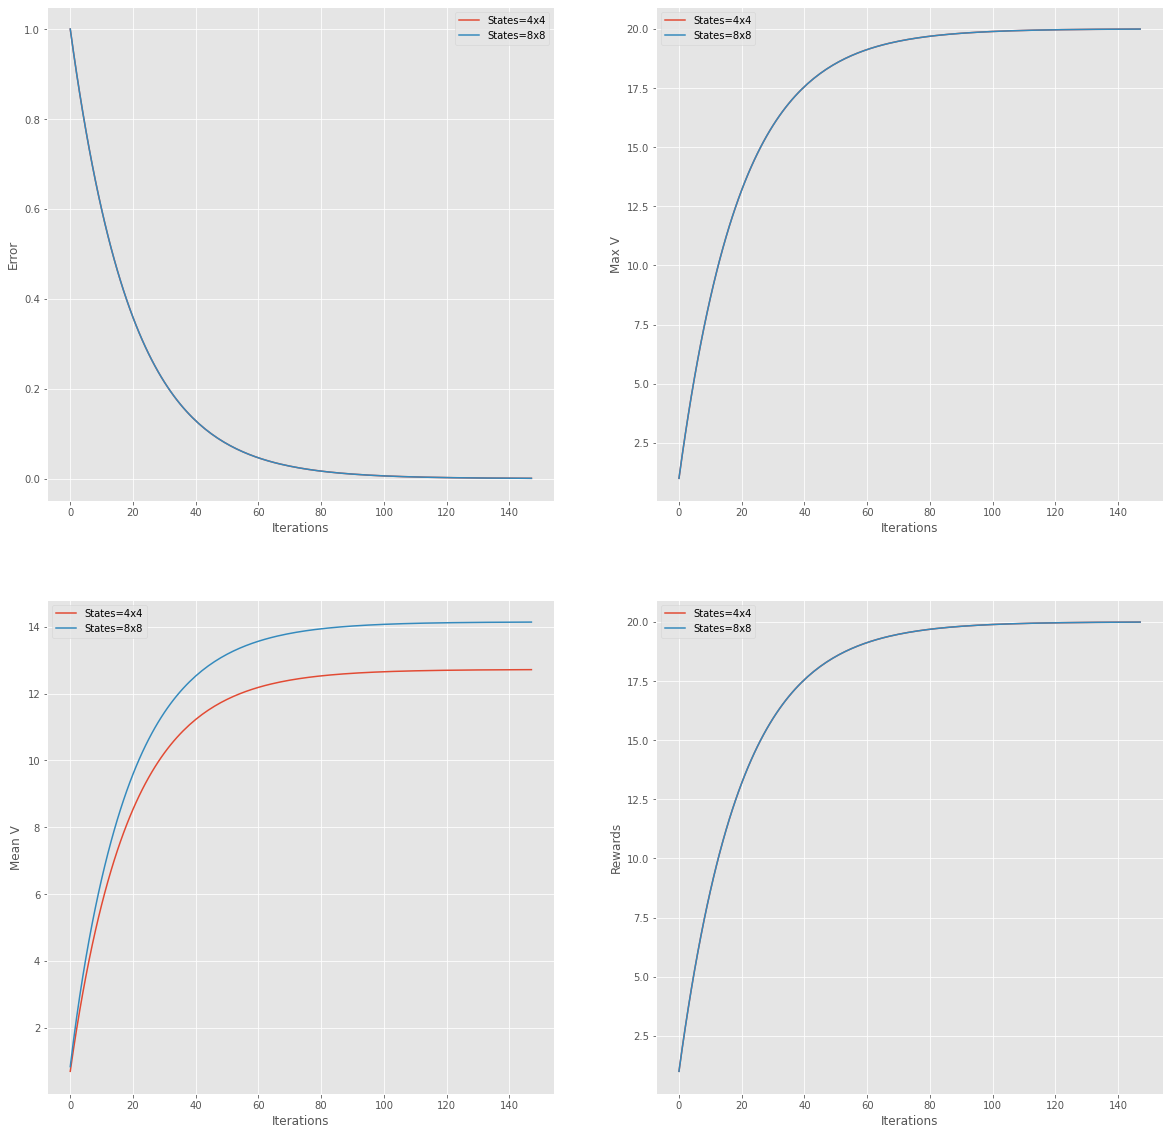

In [58]:
plt.style.use('ggplot')

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
numbering = ['a', 'b', 'c', 'd', 'e', 'f']
with open("FrozLake-VI.json") as f:
    vl_val = json.load(f)
    iterations = []
    time = []
    rewards = {}
    meanvs = {}
    maxvs = {}
    errors = {}
    for prob_size, values in vl_val.items():
        iterations.append(values[-1]['Iteration'])
        time.append(values[-1]['Time'])
        
        reward = []
        meanv = []
        maxv = []
        error = []
        for value in values:
            reward.append(value['Reward'])
            meanv.append(value['Mean V'])
            maxv.append(value['Max V'])
            error.append(value['Error'])

        rewards[prob_size] = reward
        meanvs[prob_size] = meanv
        maxvs[prob_size] = maxv
        errors[prob_size] = error
    
    for problem_size in ["4x4", "8x8"]:
        problem_size = str(problem_size)
        label = f"States={problem_size}"
        ax[0][0].plot(errors[problem_size], label=label)
        ax[0][1].plot(maxvs[problem_size], label=label)
        ax[1][0].plot(meanvs[problem_size], label=label)
        ax[1][1].plot(rewards[problem_size], label=label)
        
        ax[0][0].set_xlabel('Iterations')
        ax[0][0].set_ylabel('Error')
        ax[0][1].set_xlabel('Iterations')
        ax[0][1].set_ylabel('Max V')
        ax[1][0].set_xlabel('Iterations')
        ax[1][0].set_ylabel('Mean V')
        ax[1][1].set_xlabel('Iterations')
        ax[1][1].set_ylabel('Rewards')
        
        
    
    for i in range(0, 2):
        for j in range(0, 2):
            ax[i][j].legend(loc="best")

#### Policy Iteration - Metrics

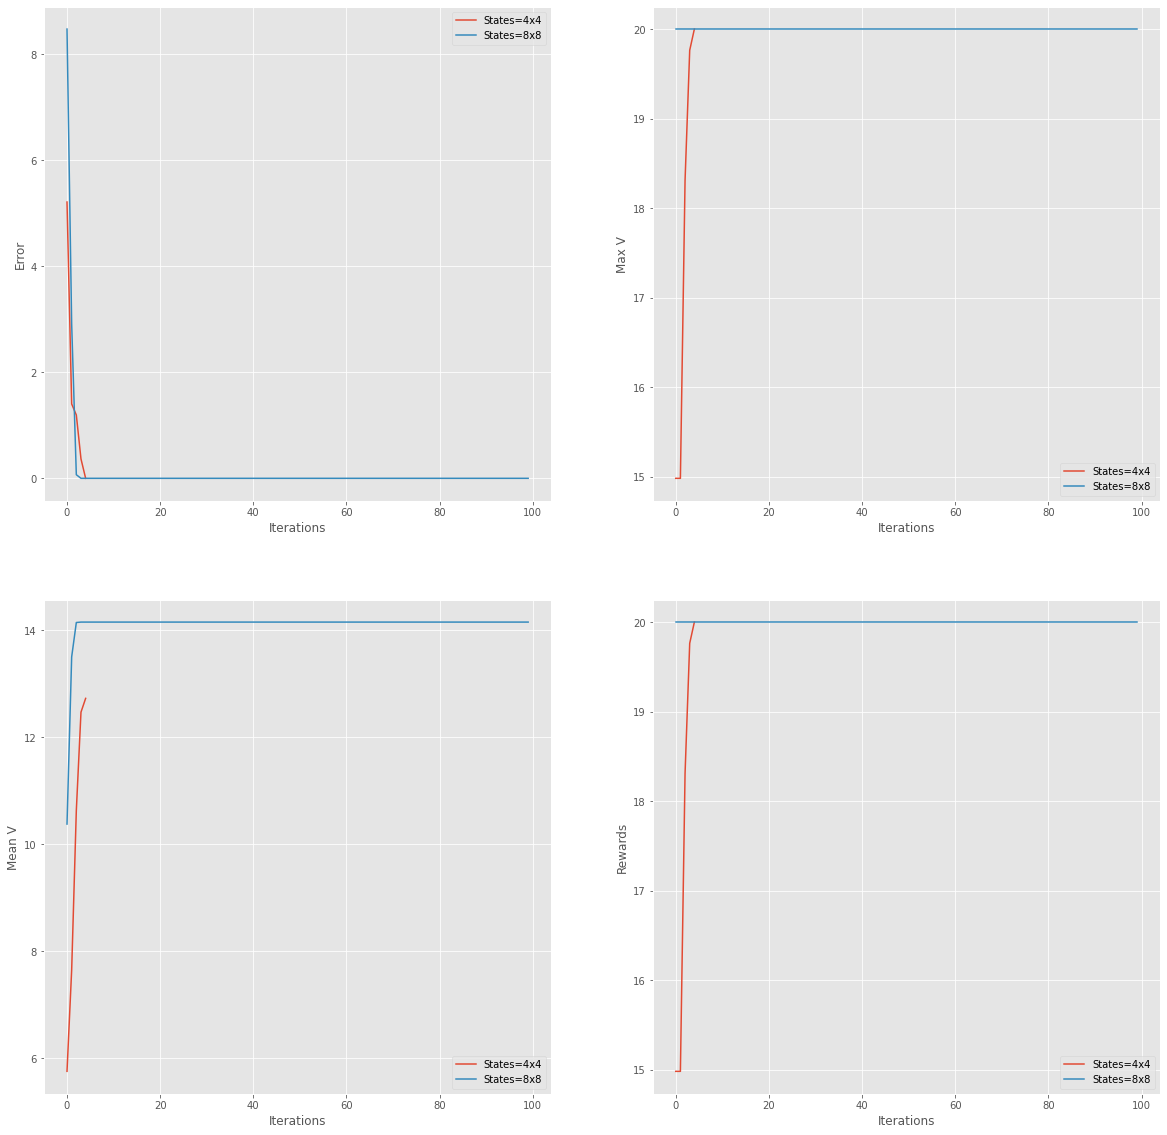

In [59]:
plt.style.use('ggplot')

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
numbering = ['a', 'b', 'c', 'd', 'e', 'f']
with open("FrozenLake-PI.json") as f:
    vl_val = json.load(f)
    iterations = []
    time = []
    rewards = {}
    meanvs = {}
    maxvs = {}
    errors = {}
    for prob_size, values in vl_val.items():
        iterations.append(values[-1]['Iteration'])
        time.append(values[-1]['Time'])
        
        reward = []
        meanv = []
        maxv = []
        error = []
        for value in values:
            reward.append(value['Reward'])
            meanv.append(value['Mean V'])
            maxv.append(value['Max V'])
            error.append(value['Error'])

        rewards[prob_size] = reward
        meanvs[prob_size] = meanv
        maxvs[prob_size] = maxv
        errors[prob_size] = error
    
    for problem_size in ["4x4", "8x8"]:
        problem_size = str(problem_size)
        label = f"States={problem_size}"
        ax[0][0].plot(errors[problem_size], label=label)
        ax[0][1].plot(maxvs[problem_size], label=label)
        ax[1][0].plot(meanvs[problem_size], label=label)
        ax[1][1].plot(rewards[problem_size], label=label)
        
        ax[0][0].set_xlabel('Iterations')
        ax[0][0].set_ylabel('Error')
        ax[0][1].set_xlabel('Iterations')
        ax[0][1].set_ylabel('Max V')
        ax[1][0].set_xlabel('Iterations')
        ax[1][0].set_ylabel('Mean V')
        ax[1][1].set_xlabel('Iterations')
        ax[1][1].set_ylabel('Rewards')
        
        
    
    for i in range(0, 2):
        for j in range(0, 2):
            ax[i][j].legend(loc="best")

#### Q-Learning - Metrics

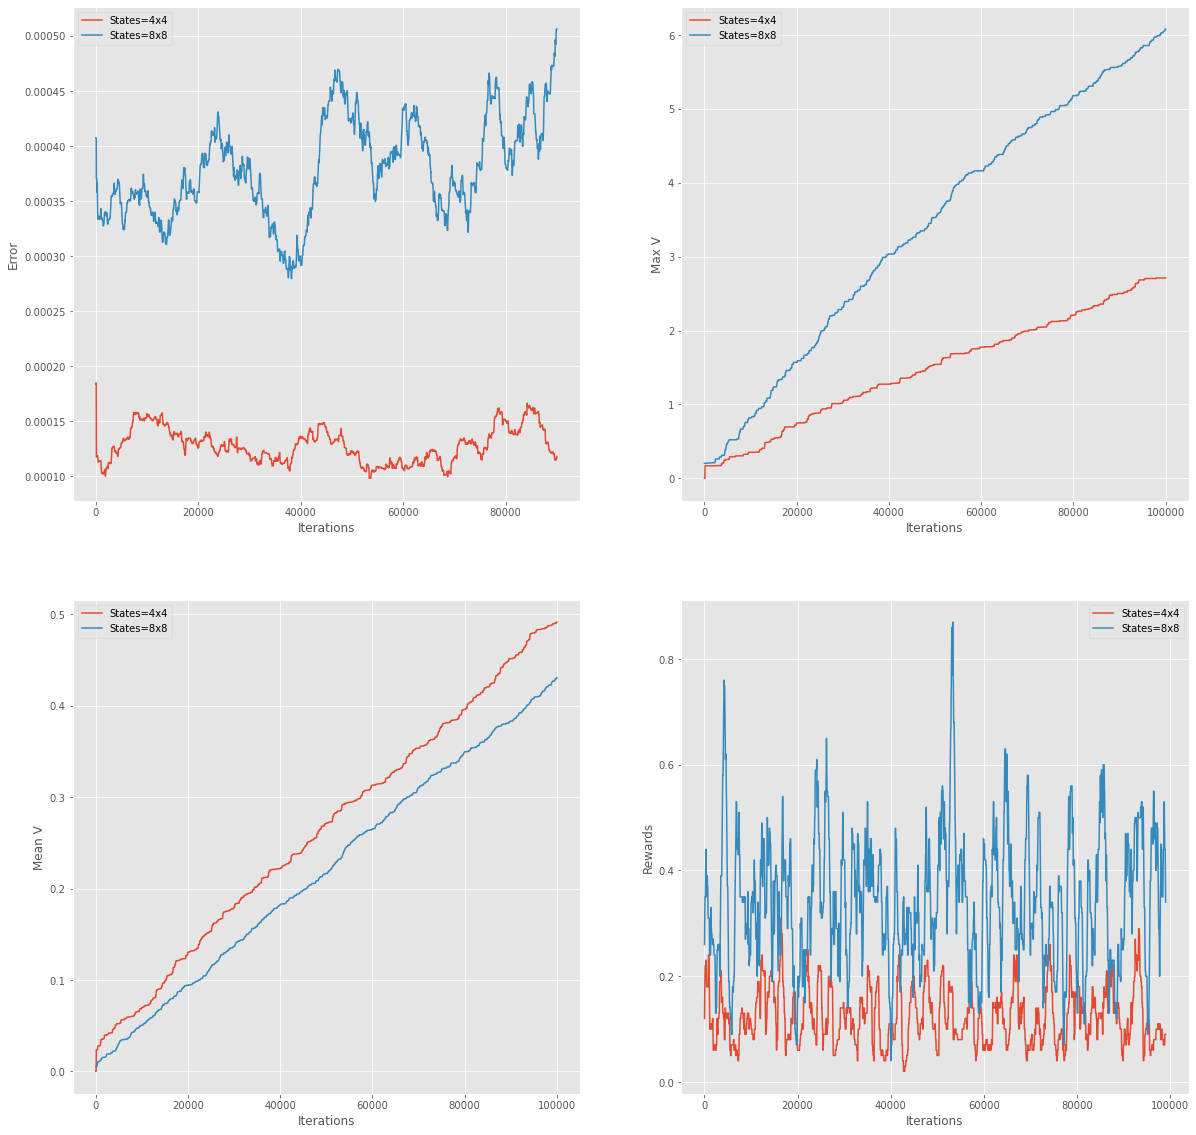

In [127]:
plt.style.use('ggplot')

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
numbering = ['a', 'b', 'c', 'd', 'e', 'f']
with open("FrozenLake-QL.json") as f:
    vl_val = json.load(f)
    iterations = []
    time = []
    rewards = {}
    meanvs = {}
    maxvs = {}
    errors = {}
    for prob_size, values in vl_val.items():
        iterations.append(values[-1]['Iteration'])
        time.append(values[-1]['Time'])
        
        reward = []
        meanv = []
        maxv = []
        error = []
        for value in values:
            reward.append(value['Reward'])
            meanv.append(value['Mean V'])
            maxv.append(value['Max V'])
            error.append(value['Error'])

        rewards[prob_size] = reward
        meanvs[prob_size] = meanv
        maxvs[prob_size] = maxv
        errors[prob_size] = error
    
    for problem_size in ["4x4", "8x8"]:
        problem_size = str(problem_size)
        label = f"States={problem_size}"
        ax[0][0].plot(range(0, 90010, 10), np.convolve(errors[problem_size], np.ones((1000,))/1000, mode='valid'), label=label)
#         ax[0][0].plot(range(0, 100000, 10), np.convolve(errors[problem_size], np.ones((1000,))/1000), label=label)
        ax[0][1].plot(range(0, 100000, 10), maxvs[problem_size], label=label)
        ax[1][0].plot(range(0, 100000, 10), meanvs[problem_size], label=label)
#         ax[1][1].plot(range(0, 100000, 10), rewards[problem_size], label=label)

        ax[1][1].plot(range(0, 99010, 10), np.convolve(rewards[problem_size], np.ones((100,))/100, mode='valid'), label=label)
        ax[0][0].set_xlabel('Iterations')
        ax[0][0].set_ylabel('Error')
        ax[0][1].set_xlabel('Iterations')
        ax[0][1].set_ylabel('Max V')
        ax[1][0].set_xlabel('Iterations')
        ax[1][0].set_ylabel('Mean V')
        ax[1][1].set_xlabel('Iterations')
        ax[1][1].set_ylabel('Rewards')
        
        
    
    for i in range(0, 2):
        for j in range(0, 2):
            ax[i][j].legend(loc="best")

## Gamma
### Value Iteration

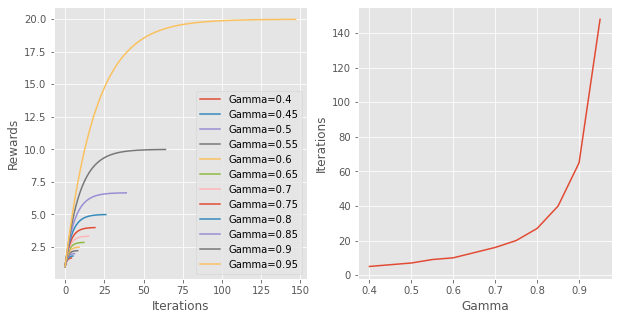

In [71]:
plt.style.use('ggplot')

gammas = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
with open("FrozLake-Gamma.json") as f:
    vl_val = json.load(f)
    rewards = {}
    iterations = []
    for gamma, values in vl_val.items():
        iterations.append(values[-1]['Iteration'])
        reward = []
        for value in values:
            reward.append(value['Reward'])
        rewards[gamma] = reward
    
    for problem_size in gammas:
        problem_size = str(problem_size)
        label = f"Gamma={problem_size}"
        ax[0].plot(rewards[problem_size], label=label)
    ax[1].plot(gammas, iterations)
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Rewards')
    ax[1].set_xlabel('Gamma')
    ax[1].set_ylabel('Iterations')

    ax[0].legend(loc="best")

### Policy Iteration

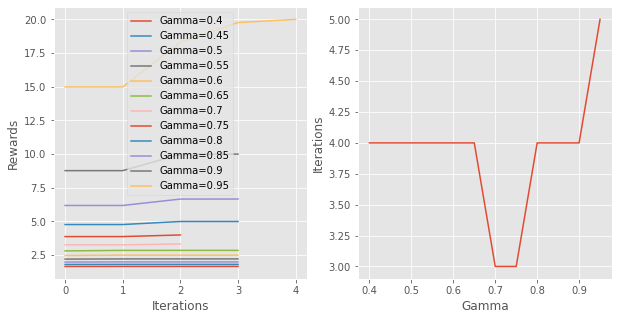

In [72]:
plt.style.use('ggplot')

gammas = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
with open("FrozenLake-Gamma-PI.json") as f:
    vl_val = json.load(f)
    rewards = {}
    iterations = []
    for gamma, values in vl_val.items():
        iterations.append(values[-1]['Iteration'])
        reward = []
        for value in values:
            reward.append(value['Reward'])
        rewards[gamma] = reward
    
    for problem_size in gammas:
        problem_size = str(problem_size)
        label = f"Gamma={problem_size}"
        ax[0].plot(rewards[problem_size], label=label)
    ax[1].plot(gammas, iterations)
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Rewards')
    ax[1].set_xlabel('Gamma')
    ax[1].set_ylabel('Iterations')

    ax[0].legend(loc="best")

### QLearning

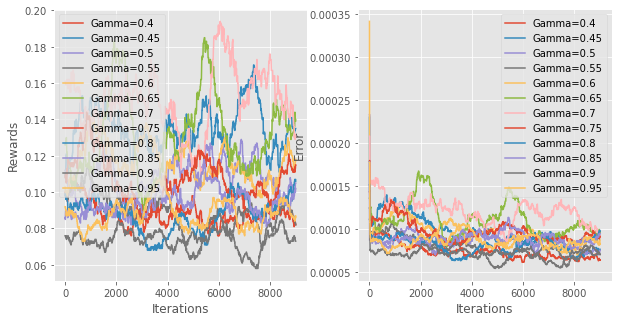

In [134]:
plt.style.use('ggplot')

gammas = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
with open("FrozenLake-Gamma-QL.json") as f:
    vl_val = json.load(f)
    rewards = {}
    error = {}
    for gamma, values in vl_val.items():
        if gamma == '1.0':
            break
        
        reward = []
        error = []
        for value in values:
            reward.append(value['Reward'])
            error.append(value['Error'])
        rewards[gamma] = reward
        errors[gamma] = error
        
    for problem_size in gammas:
        problem_size = str(problem_size)
        label = f"Gamma={problem_size}"
        ax[0].plot(np.convolve(rewards[problem_size], np.ones((1000,))/1000, mode='valid'), label=label)
        ax[0].set_xlabel('Iterations')
        ax[0].set_ylabel('Rewards')
        ax[1].plot(np.convolve(errors[problem_size], np.ones((1000,))/1000, mode='valid'), label=label)
        ax[1].set_xlabel('Iterations')
        ax[1].set_ylabel('Error')
        
    ax[0].legend(loc="best")
    ax[1].legend(loc="best")

## Q-Learning - Alpha

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



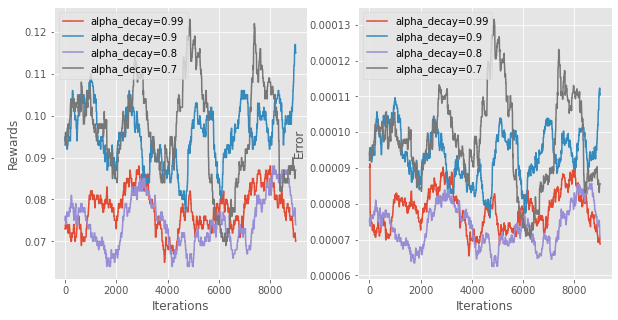

In [137]:
plt.style.use('ggplot')

ad = [0.99, 0.9, 0.8, 0.7]
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
with open("FrozenLake-alpha-QL.json") as f:
    vl_val = json.load(f)
    rewards = {}
    error = {}
    print(vl_val)
    for alpha, values in vl_val.items():
        
        reward = []
        error = []
        for value in values:
            reward.append(value['Reward'])
            error.append(value['Error'])
        rewards[alpha] = reward
        errors[alpha] = error
        
    for problem_size in ad:
        problem_size = str(problem_size)
        label = f"alpha_decay={round(eval(problem_size), 2)}"
        ax[0].plot(np.convolve(rewards[problem_size], np.ones((1000,))/1000, mode='valid'), label=label)
        ax[0].set_xlabel('Iterations')
        ax[0].set_ylabel('Rewards')
#         ax[1].plot(np.convolve(errors[problem_size], np.ones((1000,))/1000, mode='valid'), label=label)
        ax[1].plot(np.convolve(errors[problem_size], np.ones((1000,))/1000, mode='valid'), label=label)
        ax[1].set_xlabel('Iterations')
        ax[1].set_ylabel('Error')
        
    ax[0].legend(loc="best")
    ax[1].legend(loc="best")

### QLearning -  Epsilon Decay

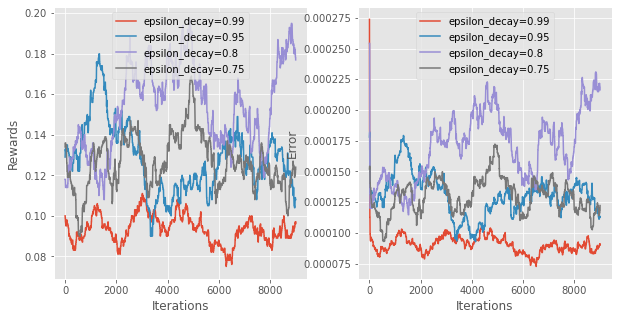

In [75]:
plt.style.use('ggplot')

epds = [0.99, 0.95, 0.8, 0.75]
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
with open("FrozenLake-epsilon-decay-QL.json") as f:
    vl_val = json.load(f)
    rewards = {}
    error = {}
    for epd, values in vl_val.items():
        
        reward = []
        error = []
        for value in values:
            reward.append(value['Reward'])
            error.append(value['Error'])
        rewards[epd] = reward
        errors[epd] = error
        
    for problem_size in epds:
        problem_size = str(problem_size)
        label = f"epsilon_decay={round(eval(problem_size), 2)}"
        ax[0].plot(np.convolve(rewards[problem_size], np.ones((1000,))/1000, mode='valid'), label=label)
        ax[0].set_xlabel('Iterations')
        ax[0].set_ylabel('Rewards')
        ax[1].plot(np.convolve(errors[problem_size], np.ones((1000,))/1000, mode='valid'), label=label)
        ax[1].set_xlabel('Iterations')
        ax[1].set_ylabel('Error')
        
    ax[0].legend(loc="best")
    ax[1].legend(loc="best")

Text(0.5, 1.0, 'Q Learning')

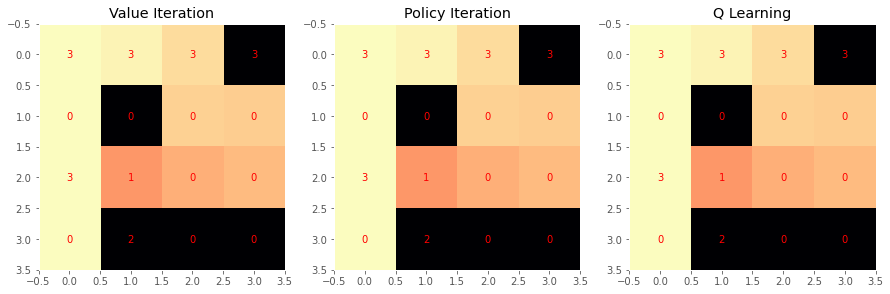

In [76]:
width = 10
fix, ax = plt.subplots(ncols=3, figsize=(15, 5))
vimat = [[vi_value[i*4+j] for i in range(4)] for j in range(4)]
vip = [[vi_policy[i*4+j] for i in range(4)] for j in range(4)]

cax = ax[0].imshow(vimat, cmap='magma');
cbar = fig.colorbar(cax)
for x in range(len(vimat)):
    for y in range(len(vimat[0])):
        ax[0].text(x, y, vip[x][y], color='red',
                horizontalalignment='center', verticalalignment='center')
ax[0].grid(False)
ax[0].set_title("Value Iteration")

pimat = [[pi_value[i*4+j] for i in range(4)] for j in range(4)]
pip = [[pi_policy[i*4+j] for i in range(4)] for j in range(4)]

cax = ax[1].imshow(pimat, cmap='magma');
cbar = fig.colorbar(cax)
for x in range(len(pimat)):
    for y in range(len(pimat[0])):
        ax[1].text(x, y, pip[x][y], color='red',
                horizontalalignment='center', verticalalignment='center')
ax[1].grid(False)
ax[1].set_title("Policy Iteration")

qlmat = [[vi_value[i*4+j] for i in range(4)] for j in range(4)]
qlip = [[vi_policy[i*4+j] for i in range(4)] for j in range(4)]

cax = ax[2].imshow(qlmat, cmap='magma');
cbar = fig.colorbar(cax)
for x in range(len(qlmat)):
    for y in range(len(qlmat[0])):
        ax[2].text(x, y, qlip[x][y], color='red',
                horizontalalignment='center', verticalalignment='center')
ax[2].grid(False)
ax[2].set_title("Q Learning")

## Visualizations for Report
1. Comparing errors for Value and Policy Iterations in 4\*4 and 8\*8

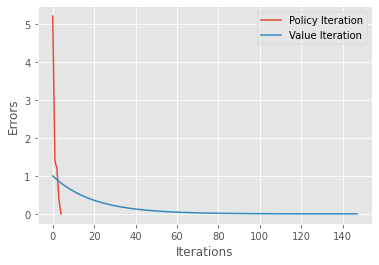

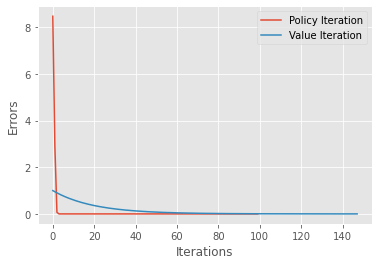

In [122]:
policy_iter = {}
value_iter = {}
with open("FrozenLake-PI.json") as f:
    policy_iter = json.load(f)
with open("FrozLake-VI.json") as f:
    value_iter = json.load(f)

for problem in ["4x4", "8x8"]:
    plt.figure()
    plt.plot([pol['Error'] for pol in policy_iter[problem]], label="Policy Iteration")
    plt.plot([val['Error'] for val in value_iter[problem]], label="Value Iteration")
    plt.legend(loc="best")
    plt.xlabel("Iterations")
    plt.ylabel("Errors")
    plt.show()

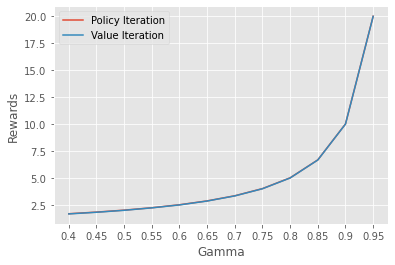

In [130]:
policy_iter = {}
value_iter = {}
with open("FrozenLake-gamma-PI.json") as f:
    policy_iter = json.load(f)
with open("FrozLake-gamma.json") as f:
    value_iter = json.load(f)

gammas = []
p = []
v = []
for gamma in policy_iter.keys():
    gammas.append(gamma)
    p.append(policy_iter[gamma][-1]['Reward'])
    v.append(value_iter[gamma][-1]['Reward'])

plt.figure()
plt.plot(gammas, p, label="Policy Iteration")
plt.plot(gammas, v, label="Value Iteration")
plt.xlabel("Gamma")
plt.ylabel("Rewards")
plt.legend(loc="best")
plt.show()

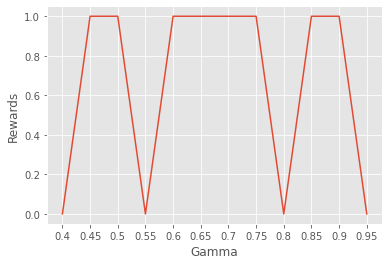

In [129]:
ql = {}
with open("FrozenLake-gamma-QL.json") as f:
    ql = json.load(f)

gammas = []
q = []
for gamma in ql.keys():
    gammas.append(gamma)
    q.append(ql[gamma][-1]['Reward'])

plt.figure()
plt.xlabel("Gamma")
plt.ylabel("Rewards")
plt.plot(gammas, q)
plt.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



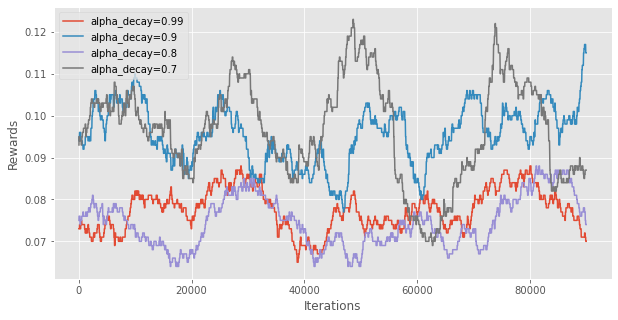

In [142]:
plt.style.use('ggplot')

ad = [0.99, 0.9, 0.8, 0.7]
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
with open("FrozenLake-alpha-QL.json") as f:
    vl_val = json.load(f)
    rewards = {}
    error = {}
    print(vl_val)
    for alpha, values in vl_val.items():
        
        reward = []
        error = []
        for value in values:
            reward.append(value['Reward'])
            error.append(value['Error'])
        rewards[alpha] = reward
        errors[alpha] = error
        
    for problem_size in ad:
        problem_size = str(problem_size)
        label = f"alpha_decay={round(eval(problem_size), 2)}"
        ax.plot(range(0, 90010, 10), np.convolve(rewards[problem_size], np.ones((1000,))/1000, mode='valid'), label=label)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Rewards')
    ax.legend(loc="best")